In [3]:
pip install lacosmic

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Boyko\\AppData\\Local\\Programs\\Python\\Python38\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [10]:
pip install Pillow

SyntaxError: invalid syntax (<ipython-input-10-a6473ff05788>, line 1)

In [11]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install bs4

  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=04e94801a248e0dd2a7e457b63500ed8de6e3c264945156b337e72aa5a90ca37
  Stored in directory: c:\users\boyko\appdata\local\pip\cache\wheels\75\78\21\68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install scipy

In [176]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from io import BytesIO
import re
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
import lacosmic
import random
import tensorflow as tf

In [177]:
BASE_URL = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/"

In [98]:
class Loader:
    def __init__(self, base_url = BASE_URL):
        self.base_url = base_url
        if not os.path.exists("Images"):
            os.mkdir("Images")
    
    def get_time(self, year, day):
        return "_".join([year, day])
    
    def get_folder_path(self, year, day):
        return "/".join(["Images", self.get_time(year, day), "img"])
    
    def get_file_path(self, year, day, image):
        return "/".join([self.get_folder_path(year, day), image])
    
    def image_exists(self, year, day, image): 
        folder_path = "/".join(["Images", self.get_time(year, day), "img"])
        filepath = self.get_folder_path(year, day)
        if not os.path.exists(filepath):
            return False
        return os.path.exists(filepath + "/" + image)
    
    def download_image(self, year, day, image):
        if self.image_exists(year, day, image):
            return None
         
        path = "_".join([year, day])
        
        if not os.path.exists("/".join(["Images", path])):
            os.mkdir("/".join(["Images", path]))
            
        filepath = "/".join(["Images", path, "img"])
        if not os.path.exists(filepath):
            os.mkdir(filepath)
            
        url = "/".join([self.base_url, path, image])
        r = requests.get(url)
        open("/".join([filepath, image]), 'wb').write(r.content)
    
    def process_img(self, year, day, image):
        img_file = open(self.get_file_path(year, day, image), "rb")
        img_bytes = bytearray()
        reading_header = True
        rows = None
        cols = None
        sample_bits = None
        for line in img_file.readlines():
            if not reading_header:
                img_bytes.extend(line)
            else:
                header_line = line.strip().decode("utf-8")
                if "END" == header_line:
                    reading_header = False
                elif "LINES" in header_line:
                    rows = int(header_line.split("=")[1])
                elif "LINE_SAMPLES" in header_line:
                    cols = int(header_line.split("=")[1])
                elif "SAMPLE_BITS" in header_line:
                    sample_bits = header_line.split("=")[1].strip()
        
        img_sample_bits = np.frombuffer(
            img_bytes,
            dtype="uint" + sample_bits
        )
        
        extra_byte_count = img_sample_bits.size - rows * cols
        img_sample_bits = img_sample_bits[extra_byte_count:]
        img_resized = np.resize(img_sample_bits, (rows,cols))
        return Image.fromarray(img_resized)
    
    def convert_all_to_png(self, year, day):
        png_dir = "/".join(["Images", self.get_time(year, day), "png"])
        if not os.path.exists(png_dir):
            os.mkdir(png_dir)
        pngs = set(os.listdir(png_dir))
        imgs = os.listdir("/".join(["Images", self.get_time(year, day), "img"]))
        for img in imgs:
            #print(img)
            if not img + ".png" in pngs:
                try:
                    im = self.process_img(year, day, img)
                    im.save("/".join([png_dir, img]) + ".png",format="png")
                except:
                    print("FAILED:" + img)
                    
    def download_and_display_image(self, year, day, image, display=False):
        self.download_image(year, day, image)
        im = self.process_img(year, day, image)
        if display:
            plt.figure()
            plt.imshow(np.asarray(im), cmap="gray", vmin=0, vmax=255)
#             im = Image.open("")
#            im.show()
        
    def download_and_display_all_images_from_folder(self, year, day, display=False):
        time = self.get_time(year, day)
        url = "/".join([self.base_url, time])
        request = requests.get(url)
        soup = BeautifulSoup(request.content, "html.parser")
        print("Retrieving folder content")
        images = soup.find_all("a", text=re.compile(".IMG"))
        x = 0
        for image in images:
            print(x)
            self.download_and_display_image(year, day, image.get_text(), display)
            x += 1
            print(str(x) + "/" + str(len(images)), end="\r", flush=True)

In [182]:
def get_bounding_box(r, c, mask):
    padding = 30
    dirs =  []
    for p in range(1, padding):
        dirs.append([0, p])
        dirs.append([p, 0])
        dirs.append([0, -p])
        dirs.append([-p, 0])
        dirs.append([p, p])
        dirs.append([p, -p])
        dirs.append([-p, p])
        dirs.append([-p, -p])
    max_r = r
    min_r = r
    max_c = c
    min_c = c
    q = []
    q.append([r, c])
    while (len(q) > 0):
        [cr, cc] = q.pop(0)
        mask[cr, cc] = False
        for d in dirs:
            nr = cr + d[0]
            nc = cc + d[1]
            if nr > 0 and nr < len(mask) and nc > 0 and nc < len(mask[0]):
                max_r = max(nr, max_r)
                min_r = min(nr, min_r)
                max_c = max(nc, max_c)
                min_c = min(nc, min_c)
            if nr > 0 and nr < len(mask) and nc > 0 and nc < len(mask[0]) and mask[nr][nc]:
                mask[nr, nc] = False
                q.append([nr, nc])
    return [max_r, min_r, max_c, min_c]
    
class Image_processor:
    def __init__(self, year, day):
        self.day_path = "/".join(["Images", year + "_" + day, "png"])
    
    def process_single_image_cosmic_rays(self, image):
        folder_name = self.day_path + "/" + image + "_" + "processed"
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        imgpath = self.day_path + "/" + image
        imgpng = np.array(Image.open(imgpath).convert("L"))
        print(imgpng.shape)
        (img, mask) = lacosmic.lacosmic(imgpng.astype(np.float), contrast=3.0, cr_threshold=3.75, 
                                        neighbor_threshold=0.3, effective_gain=1.0,
                                        readnoise= 4.5, maxiter=1, border_mode=u'mirror',
                                        background=None, mask=None, error=None)
        
        boxes = []
        print("Getting bounding boxes")
        for r in range(len(mask)):
            for c in range(len(mask[0])):
                if mask[r, c]:
                    boxes.append(get_bounding_box(r, c, mask))
        
        #im = Image.fromarray(np.where(mask == False, img, 0))#img)
        print("Number of boxes: " + str(len(boxes)))
        im = Image.fromarray(img)
        i = 1
        for box in boxes:
            for x in range(len(box)):
                r = random.random()
                if r < 0.1:
                    box[x] += 10
                if r >= 0.95:
                    box[x] += + 15
            [max_r, min_r, max_c, min_c] = box
            cosmic_ray_candidate = Image.open(imgpath).crop((min_c, min_r, max_c, max_r)).convert("RGB")
            cosmic_ray_candidate.save(folder_name + "/" + str(i) + ".png")#, format="png")
            i += 1
    
    def process_folder_cosmic_rays(self):
        j = 0
        m = len(os.listdir(self.day_path))
        for file in os.listdir(self.day_path):
#             print (str(j) + "/" + str(m))
            j += 1
            if file.endswith(".png"):
                self.process_single_image_cosmic_rays(file)
                
    def process_single_image_random_sample(self, image):
        folder_name = self.day_path + "/" + image + "_" + "processed"
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        imgpath = self.day_path + "/" + image
        img = Image.open(imgpath)
        max_width, max_height = img.size
        cols = np.random.randint(low = 1, high = max_width, size = 120)
        rows = np.random.randint(low = 1, high = max_height, size = 120)
        for i in range(120):
            default_padding = 30
            borders = [max(0, cols[i] - 30), max(0, rows[i] - 30), min(cols[i] + 30, max_width - 1), min(rows[i] + 30, max_height - 1)]
            for x in range(len(borders)):
                r = random.random()
                if r < 0.1:
                    borders[x] += 10
                if r >= 0.95:
                    borders[x] += + 15
            random_img = img.crop((borders[0], borders[1], borders[2], borders[3])).convert("RGB")
            random_img.save(folder_name + "/" + str(i) + ".png")

    def process_folder_random_images(self):
        j = 0
        m = len(os.listdir(self.day_path))
        for file in os.listdir(self.day_path):
#             print (str(j) + "/" + str(m), end="\r", flush=True)
#             j += 1
            if file.endswith(".png"):
                self.process_single_image_random_sample(file)
    
    def get_data_single_image(self, directory_path):
        images = []
        for file in os.listdir(directory_path):
            img = Image.open(directory_path + "/" + file).resize((50, 50))
            img = ImageEnhance.Contrast(img).enhance(3)
            im = np.array(img, dtype="f")
            images.append(im)
        return np.array(images, dtype="f")
    
    def load_day(self):
        samples = []
        i = 0
        j = len(os.listdir(self.day_path))
        for file in os.listdir(self.day_path):
            if file.endswith("_processed"):
                image_samples = self.get_data_single_image(self.day_path + "/" + file)
                samples.extend(image_samples)
            i += 1
            print (str(i) + "/" + str(j), end="\r", flush=True)
        return np.array(samples)

# Step 1 – Retrieving and Plotting Image Files
### The utility Loader defined above class was developed for this task, which facilitates downloading and storing images in the file structure assumed by the tools for the other task and plotting images

In [168]:
l = Loader()
l.download_and_display_all_images_from_folder("2011", "156", display=False)

###TRIAL TASK
l.download_and_display_all_images_from_folder("2011", "207", display=True)

KeyboardInterrupt: 

In [ ]:
###Displaying 2011_207/EW0220137668G.IMG
###Dsiplaying 2014_215/EN1049375684M.IMG
l.download_and_display_image("2011", "207", "EW0220137668G.IMG", display=True)
l.download_and_display_image("2014", "215", "EN1049375684M.IMG", display=True)

# Step 2 – Dataset preparation

For automation of the labeling process for cosmic rays, the L.A. Cosmic algorithm, that utilises Laplacian edge detection, was used:

https://lacosmic.readthedocs.io/en/latest/

L.A. cosmic generates a mask that indicate where cosmic rays could be located. The cosmic ray islands are then boxed into 60x60 squares. If two boxes overlap, they are merged. To reduce bias for all cosmic rays being positioned in the center of the frame, image augmentation is used. There is a 10% probability for 10 pixels to be trimmed from each side and a 5% probability for 15 pixels to be removed.

For labeling images with no cosmic rays, a day was picked out manually where images did not contain many cosmic ray and random segments of these images were cut out. The images were trimmed in the exact same way mentioned above to avoid the neural network detecting image streching traces as a feature to classify on. 

The contrast was tripled on all images so as to make Cosmic Rays more easily detectable.

In [183]:

# l = Loader()
# $l.convert_all_to_png("2014", "215")
# l.display_image("2011", "207","EW0220137668G.IMG")
# l.display_image("2014", "215", "EN1049375684M.IMG")
#col.display_all_images_from_folder("2011", "207")
# try:
# l.download_and_display_all_images_from_folder("2011", "155")
# except: 
#     print("Unexpected error:", sys.exc_info()[0])
#     print("FAIL")
# try:
#     l.display_all_images_from_folder("2011", "156")
# except:
#     print("Unexpected error:", sys.exc_info()[0])
#     print("FAIL")
# try:
#     l.display_all_images_from_folder("2011", "157")
# except:
#     print("Unexpected error:", sys.exc_info()[0])
#     print("FAIL")
# l.convert_all_to_png("2011", "207")

i_cosmic_ray = Image_processor("2011", "156")
# i_cosmic_ray.process_folder_cosmic_rays()
cosmic_ray_data = i_cosmic_ray.load_day()
print(cosmic_ray_data.shape)
i_non_cosmic_ray = Image_processor("2011", "207")
i_non_cosmic_ray.process_folder_random_images()
non_cosmic_ray_data = i_non_cosmic_ray.load_day()
print(non_cosmic_ray_data.shape)

(12843, 50, 50, 3)
(14320, 50, 50, 3)


In [ ]:
# print(cosmic_ray_data[25].shape)
# Image.fromarray(cosmic_ray_data[10].astype(np.uint8)).show()
# print(non_cosmic_ray_data[25].shape)
# Image.fromarray(non_cosmic_ray_data[10].astype(np.uint8)).show()

In [184]:
#Prepare data for classification
data = np.concatenate((non_cosmic_ray_data, cosmic_ray_data), axis = 0) / 255.0
labels = np.zeros(data.shape[0])#, 2))
labels[:non_cosmic_ray_data.shape[0]] = 0#[0, 1] 
labels[non_cosmic_ray_data.shape[0]:] = 1#[1, 0]
indecies = np.arange(data.shape[0])
np.random.shuffle(indecies)
labels = labels[indecies]
data = data[indecies]

#Leave 1/5 of data for testing
slice_index = int(labels.shape[0] / 5)
training_data = data[slice_index:]
training_labels = labels[slice_index:]
test_data = data[:slice_index]
test_labels = labels[:slice_index]
print("Training data shape: ", training_data.shape)
print("Test data shape: ", test_data.shape)
print(labels)
# Image.fromarray((training_data[25] * 255).astype(np.uint8)).show()

Training data shape:  (21731, 50, 50, 3)
Test data shape:  (5432, 50, 50, 3)
[0. 0. 0. ... 1. 1. 0.]


# Step 3 – Machine Learning Algorithm

The following CNN model is to be used for binary classification, where 1 is the label for cosmic rays and 0 is the label for non-cosmic ray images.

In [194]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    return cnn_model
    
cnn_model = build_cnn_model()
# print(training_data[0].shape)
print(cnn_model.predict(training_data[[0]]))
print(cnn_model.summary())

[[0.49496767]]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               991360    
_________________________________________________________________
dense_40 (Dense)             (None, 1)

In [195]:
BATCH_SIZE = 3000
EPOCHS = 7 #Experimentation with further training to increase accuracy showed overfitting

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.fit(x=training_data, y=training_labels, batch_size = BATCH_SIZE, epochs=EPOCHS)

Epoch 1/7
8/8 [==============================] - 25s 3s/step - loss: 0.6299 - accuracy: 0.5331
Epoch 2/7
8/8 [==============================] - 23s 3s/step - loss: 0.5263 - accuracy: 0.6686
Epoch 3/7
8/8 [==============================] - 24s 3s/step - loss: 0.3830 - accuracy: 0.8621
Epoch 4/7
8/8 [==============================] - 24s 3s/step - loss: 0.2972 - accuracy: 0.8634
Epoch 5/7
8/8 [==============================] - 24s 3s/step - loss: 0.2581 - accuracy: 0.8842
Epoch 6/7
8/8 [==============================] - 24s 3s/step - loss: 0.2267 - accuracy: 0.9154
Epoch 7/7
8/8 [==============================] - 24s 3s/step - loss: 0.2024 - accuracy: 0.9338


In [196]:
test_loss, test_acc = cnn_model.evaluate(test_data, test_labels)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

170/170 [==============================] - 2s 9ms/step - loss: 0.1812 - accuracy: 0.9411
Test accuracy 0.9410898089408875
Test loss 0.18118973076343536


# Pipeline for ingesting a single image

The current network can be used to identify tiles that potentially contain cosmic rays.

Original image:


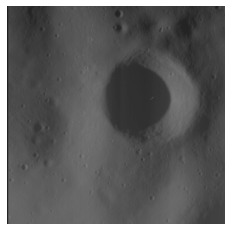

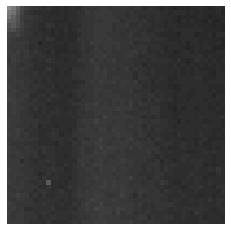

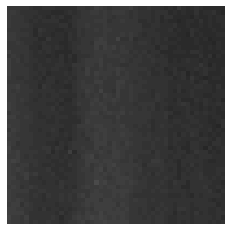

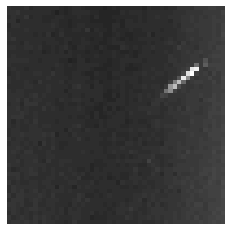

In [197]:
def ingest_image(image_png_path):
    image = Image.open(image_png_path)
    print("Original image:")
    plt.figure()
    plt.axis('off')
    plt.imshow(np.asarray(image), cmap="gray", vmin=0, vmax=255)
    width, height = image.size
    length = 50
    window = 50
    r = 0
    c = 0
    while r < height:
        c = 0
        while c < width:
            im = image.crop((c, r, min(c + length, width), min(r + length, height))).resize((length, length)).convert("RGB")
            im = ImageEnhance.Contrast(im).enhance(4)
            arr = np.array(im) / 255.0
            ar = np.expand_dims(arr, axis=0)
            prediction = cnn_model.predict(ar)
            if (prediction[0] > 0.50):
#                 print("Prediction value: ",prediction[0])
                plt.figure()
                plt.axis('off')
                plt.imshow(np.asarray(im), cmap="gray", vmin=0, vmax=255)
            c += window
        r += window

ingest_image("/".join(["Images", "2014_215", "png", "EN1049375684M.IMG.png"]))